# 4: Macro and Micro Regions Analysis

Demonstrate the usage of SpatialCells to extract region components or holes for fine-grained analysis into cell types.

@author: Guihong Wan and Boshen Yan      
@date: Aug 20, 2023    
@last updated: Oct 6, 2023

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import anndata as ad
import seaborn as sns
import statistics
import spatialcells as spc

## Read data

In [3]:
adata = ad.read_h5ad("../../data/MEL1_adata.h5ad")
adata.obs["id"] = adata.obs_names

In [4]:
adata.var_names

Index(['SOX10_cellRingMask', 'KERATIN_cellRingMask', 'CD3D_cellRingMask',
       'MITF_cellRingMask', 'KI67_cellRingMask', 'CCND1_cellRingMask'],
      dtype='object')

## setGate or setGates

This package relies on gated biomarkers in adata.obs

If gating has not yet been performed, `setGate` and `setGates` are convenience functions to gate the dataset manually or via a csv file

In [6]:
spc.prep.setGate(adata, "SOX10_cellRingMask", 7.9, debug=True)
spc.prep.setGate(adata, "CCND1_cellRingMask", 7.5, debug=True)

adata.obs["CCND1_negative"] = ~adata.obs["CCND1_cellRingMask_positive"]
adata.obs["SOX10+CCND1-"] = adata.obs["SOX10_cellRingMask_positive"] & adata.obs["CCND1_negative"]

SOX10_cellRingMask_positive
False    566576
True     544009
Name: count, dtype: int64
CCND1_cellRingMask_positive
False    827121
True     283464
Name: count, dtype: int64


Visualizing cells with markers of interest

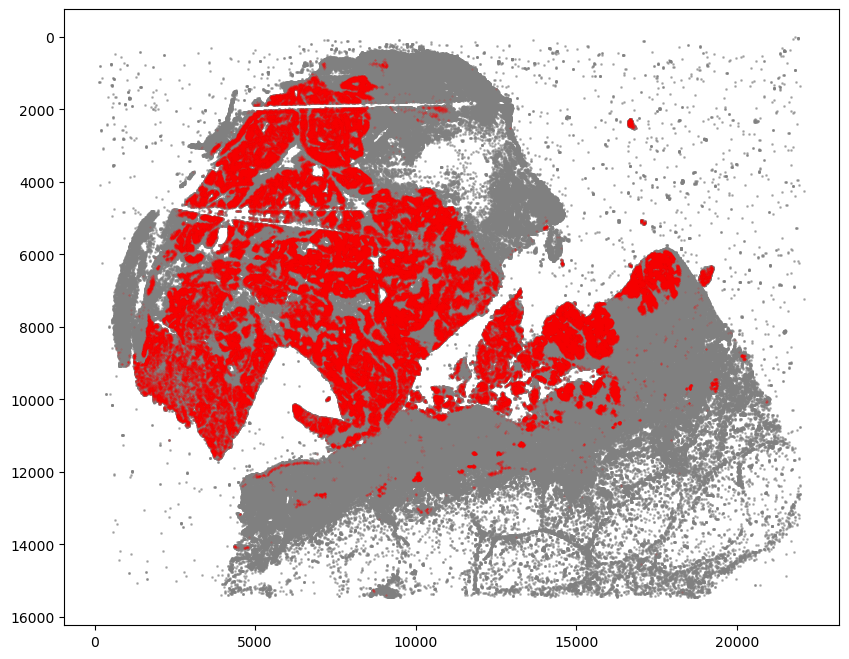

In [7]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.invert_yaxis()

## all points
ax.scatter(
    *zip(*adata.obs[["X_centroid", "Y_centroid"]].to_numpy()),
    s=1,
    color="grey",
    alpha=0.5
)
## SOX10+CCND1- cells
tmp = adata[adata.obs["SOX10+CCND1-"]]
ax.scatter(
    *zip(*tmp.obs[["X_centroid", "Y_centroid"]].to_numpy()),
    s=0.1,
    color="red",
    alpha=0.3
)
plt.show()

## getCommunities

We first use DBSCAN via `getCommunities` to identify regions with high densities of markers of interest. 

In [15]:
markers_of_interest = ["SOX10+CCND1-"]
communitycolumn = "COI_community"
ret = spc.spatial.getCommunities(
    adata,
    markers_of_interest,
    eps=55,  # smaller --> more cells are considered as outliers.
    newcolumn=communitycolumn,
    min_samples=5,
    core_only=True,
)
print("number of communities:", len(ret[0]))

number of communities: 149


In [16]:
help(spc.plt.plotCommunities)

Help on function plotCommunities in module spatialcells.plotting._plotCommunities:

plotCommunities(adata, ret, communitycolumn, plot_first_n_clusters=10, **kwargs)
    Plot largest communities on a scatter plot. Each community is labelled as:
    (rank in descending number of cells : index of community)
    
    :param adata: AnnData object
    :param ret: return value of spc.spa.getCommunities
    :param communitycolumn: column name of the community column in adata.obs
    :param plot_first_n_clusters: plot and number the largest n communities
    :param kwargs: keyword arguments for matplotlib.pyplot.plot



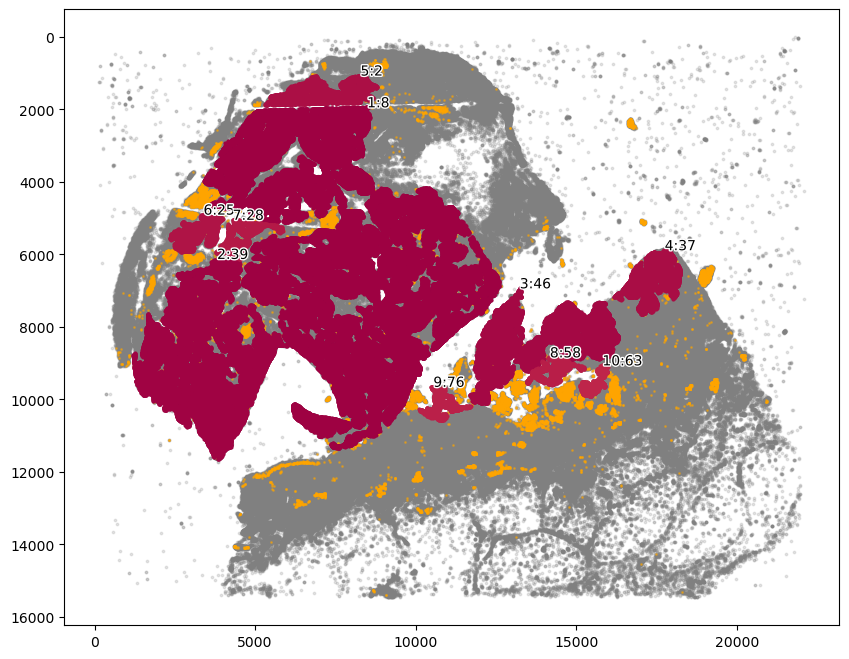

In [17]:
fig, ax = plt.subplots(figsize=(10, 8))
spc.plt.plotCommunities(
    adata, ret, communitycolumn, plot_first_n_clusters=10, s=2, fontsize=10, ax=ax
)
ax.invert_yaxis()
plt.show()

In [18]:
plot_first_n_clusters = 10
clusters_idx_sorted = [idx for npoints, idx in ret[0]]
print(
    "Indexes of the",
    plot_first_n_clusters,
    "largest clusters:\n",
    clusters_idx_sorted[:plot_first_n_clusters],
)
print("Cluster size and index:\n", ret[0][:plot_first_n_clusters])

# Here we choose the three largest ones of interest based on their index:
communityIndexList = [2, 8, 25, 28, 39]

Indexes of the 10 largest clusters:
 [8, 39, 46, 37, 2, 25, 28, 58, 76, 63]
Cluster size and index:
 [(165231, 8), (41772, 39), (29115, 46), (11021, 37), (7557, 2), (4439, 25), (3337, 28), (2560, 58), (1844, 76), (1778, 63)]


## getBoundary    

In [19]:
help(spc.spatial.getBoundary)

Help on function getBoundary in module spatialcells.spatial._getBoundary:

getBoundary(anndata, communitycolumn, communityIndexList, alpha=100, debug=False)
    Get a boundary for the communities of interest as a Shapely MultiPolygon.
    
    The boundary is defined based on the alpha shape of points in the
    communities. The alpha shape is the generalization of the convex hull,
    and is generated via Delaunay triangulation of all the points of interest.
    The alpha parameter controls the longest edge that can appear in the alpha
    shape. Smaller alpha gives more detailed boundary, but may appear more
    jagged and may leave out some points that are too far away from the rest
    of the points.
    
    :param anndata: the anndata object
    :param communitycolumn: the column name of the community
    :param communityIndexList: the list of community indexes
    :param alpha: the alpha parameter for alpha shape. Smaller alpha gives
        more detailed boundary, but may appea

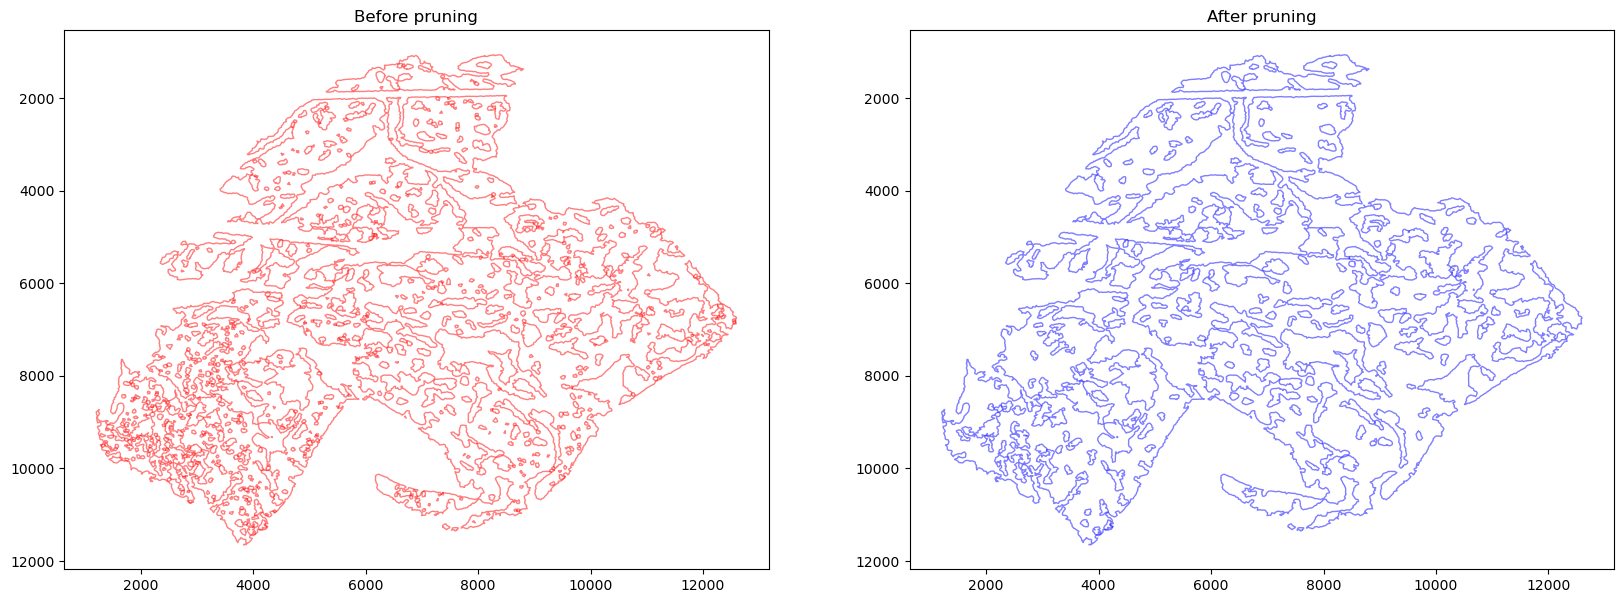

In [20]:
# smaller alpha results in more detailed boundaries
boundaries, polygons, edge_components = spc.spatial.getBoundary(
    adata, communitycolumn, communityIndexList, alpha=27, debug=True
)
boundaries1 = spc.spatial.pruneSmallComponents(
    boundaries, min_area=0, min_edges=20, holes_min_area=10000, holes_min_edges=10
)
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 7))
spc.plt.plotBoundary(boundaries, c="red", alpha=0.5, linewidth=1, ax=ax1)
spc.plt.plotBoundary(boundaries1, c="blue", alpha=0.5, linewidth=1, ax=ax2)
ax1.set_title("Before pruning")
ax2.set_title("After pruning")
ax1.invert_yaxis()
ax2.invert_yaxis()
plt.show()

#### Isolate and plot each boundary component (for demo)

In [21]:
help(spc.spa.getComponents)

Help on function getComponents in module spatialcells.spatial._utils:

getComponents(boundary, keep_holes=True)
    Get the components of a boundary defined by a MultiPolygon.
    
    :param boundary: the boundary to get components from
    :param keep_holes: whether to keep holes
    :returns: a list of components, where each component is a MultiPolygon



Number of components: 24


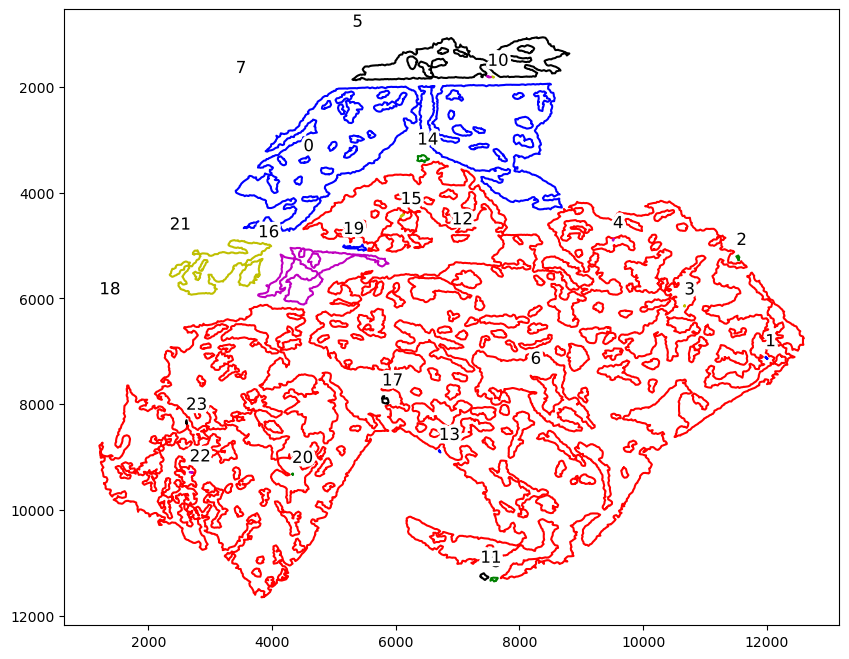

In [22]:
boundary_component_list = spc.spa.getComponents(boundaries1)
print("Number of components:", len(boundary_component_list))
fig, ax = plt.subplots(figsize=(10, 8))
spc.plt.plotRegions(
    boundary_component_list,
    colors_list=["r", "b", "g", "y", "m", "k"],
    x_offset=0,
    y_offset=-200,
    ax=ax,
)
ax.invert_yaxis()
plt.show()

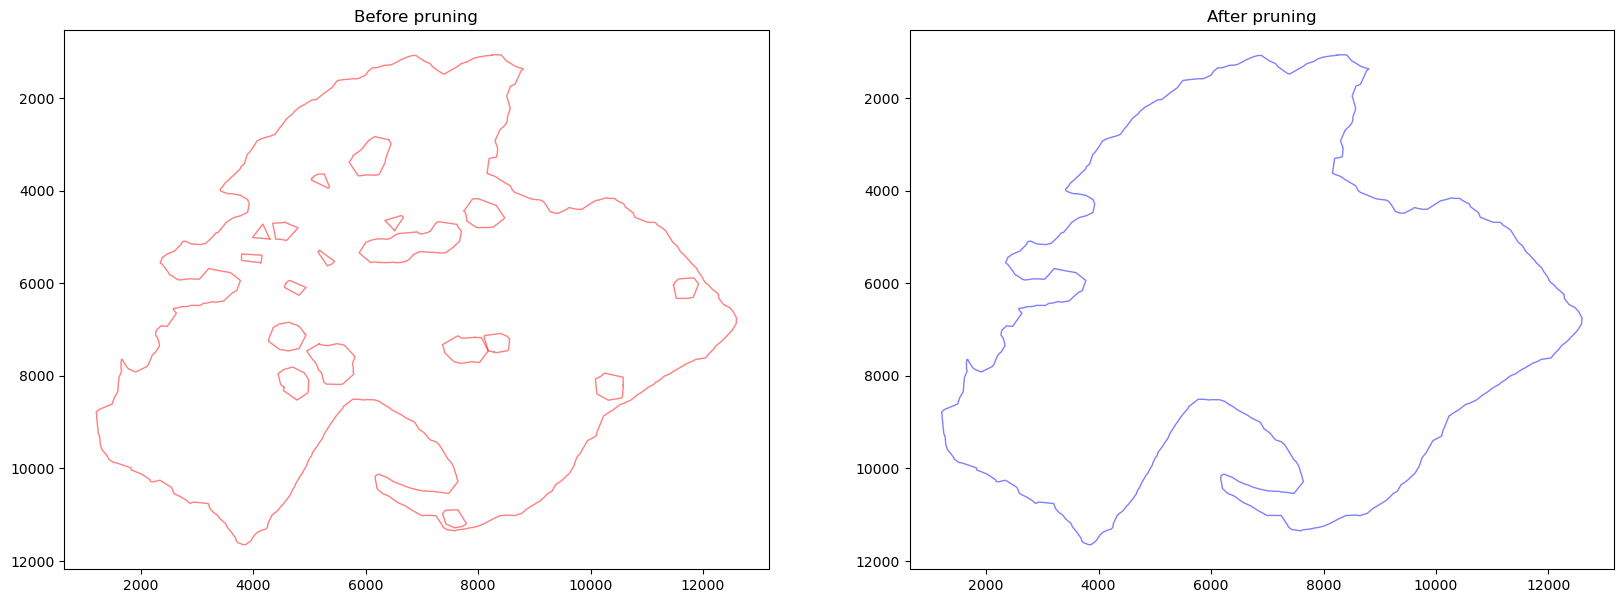

In [23]:
# larger alpha results in more rough boundaries with less jagged exterior
boundaries_rough, polygons_rough, edge_components_rough = spc.spatial.getBoundary(
    adata, communitycolumn, communityIndexList, alpha=180, debug=True
)
boundaries_rough1 = spc.spatial.pruneSmallComponents(
    boundaries_rough,
    min_area=100000,
    min_edges=30,
    holes_min_area=4000,
    holes_min_edges=3000,
)
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 7))
spc.plt.plotBoundary(boundaries_rough, c="red", alpha=0.5, linewidth=1, ax=ax1)
spc.plt.plotBoundary(boundaries_rough1, c="blue", alpha=0.5, linewidth=1, ax=ax2)
ax1.set_title("Before pruning")
ax2.set_title("After pruning")
ax1.invert_yaxis()
ax2.invert_yaxis()
plt.show()

Visualization of regions of interest and boundary

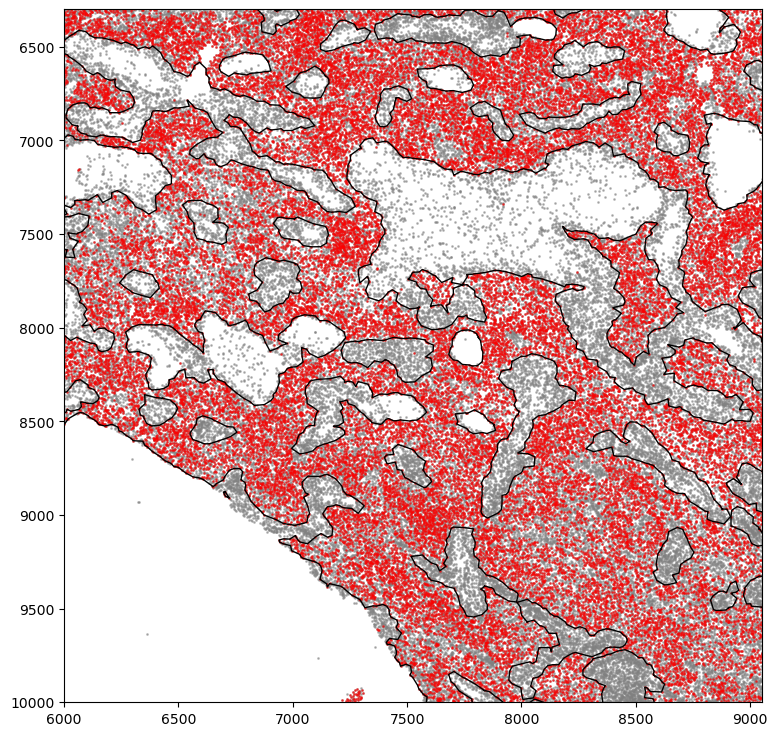

In [24]:
markersize = 1

fig, ax = plt.subplots(figsize=(9, 9))

## all points
ax.scatter(
    *zip(*adata.obs[["X_centroid", "Y_centroid"]].to_numpy()),
    s=markersize,
    color="grey",
    alpha=0.5,
    label="All cells"
)

# Points in selected commnities
xy = adata.obs[
    adata.obs["SOX10+CCND1-"]
][  # [adata.obs[communitycolumn].isin(communityIndexList)][
    ["X_centroid", "Y_centroid"]
].to_numpy()
ax.scatter(
    xy[:, 0],
    xy[:, 1],
    s=markersize,
    color="r",
    marker="o",
    alpha=0.5,
    label="SOX10+CCND1- cells",
)

# Bounds of points in selected commnities
spc.plt.plotBoundary(boundaries1, linewidth=1, color="k", ax=ax)
plt.ylim(6300, 10000)
plt.xlim(6000, 9050)
ax.invert_yaxis()
# plt.legend(loc="lower left", markerscale=5)
# plt.savefig("5_micro_region_zoom.png", dpi=300)
plt.show()

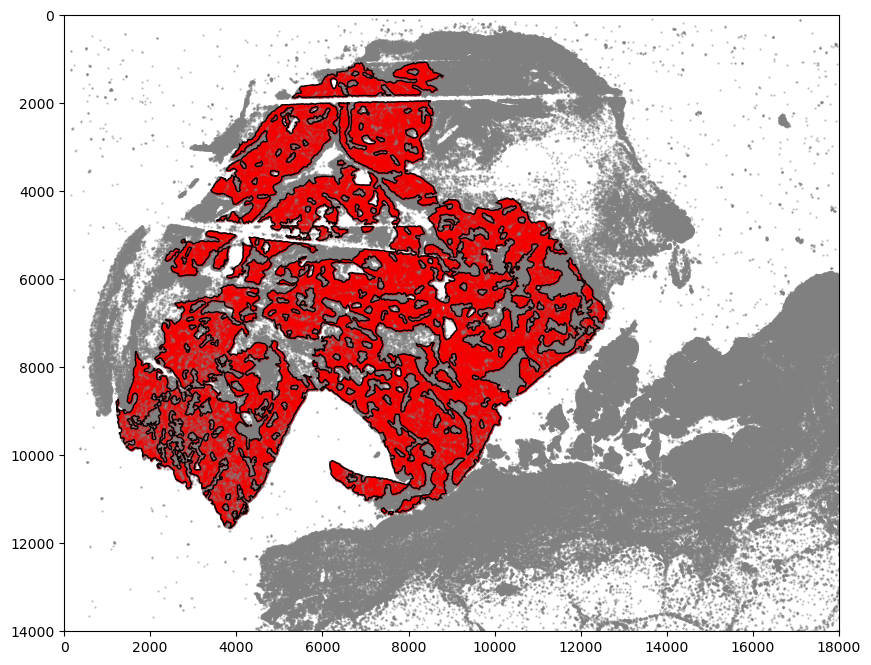

In [25]:
markersize = 0.3

fig, ax = plt.subplots(figsize=(10, 8))

## all points
ax.scatter(
    *zip(*adata.obs[["X_centroid", "Y_centroid"]].to_numpy()),
    s=markersize,
    color="grey",
    alpha=0.5,
    label="All cells"
)

# Points in selected commnities
xy = adata.obs[
    adata.obs[communitycolumn].isin(communityIndexList)
][  # adata.obs[adata.obs["SOX10+CCND1-"]][
    ["X_centroid", "Y_centroid"]
].to_numpy()
ax.scatter(
    xy[:, 0],
    xy[:, 1],
    s=markersize,
    color="r",
    marker="o",
    alpha=0.2,
    label="SOX10+CCND1- cells",
)

# Bounds of points in selected commnities
spc.plt.plotBoundary(boundaries1, linewidth=1, color="k", ax=ax)
ax.invert_yaxis()
plt.ylim(14000, 0)
plt.xlim(0, 18000)
# plt.legend(loc="lower left", markerscale=5)
# plt.savefig("5_micro_region.png", dpi=300)
plt.show()

## getExtendedBoundary & getShrunkenBoundary

`getExtendedBoundary` and `getShrunkenBoundary` can be used to expand or shrink the current boundary, which is useful to generate regions of interest

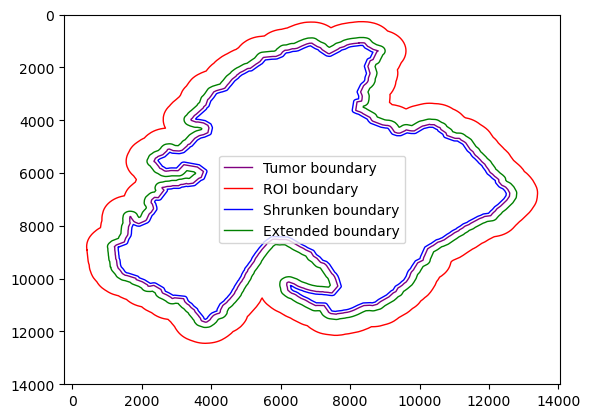

In [26]:
shrunken_boundaries_rough = spc.spa.getShrunkenBoundary(boundaries_rough1, 100)
shrunken_boundaries_rough = spc.spatial.pruneSmallComponents(
    shrunken_boundaries_rough,
    min_area=0,
    min_edges=10,
    holes_min_area=1000,
    holes_min_edges=10,
)
extended_boundaries_rough = spc.spa.getExtendedBoundary(boundaries_rough1, 200)
extended_boundaries_rough = spc.spatial.pruneSmallComponents(
    extended_boundaries_rough,
    min_area=0,
    min_edges=10,
    holes_min_area=1000,
    holes_min_edges=10,
)
ROI_boundaries_rough = spc.spa.getExtendedBoundary(boundaries_rough1, 800)
ROI_boundaries_rough = spc.spatial.pruneSmallComponents(
    ROI_boundaries_rough,
    min_area=0,
    min_edges=20,
    holes_min_area=1000,
    holes_min_edges=10,
)

spc.plt.plotBoundary(
    boundaries_rough1, linewidth=1, color="purple", label="Tumor boundary"
)
spc.plt.plotBoundary(
    ROI_boundaries_rough, linewidth=1, color="red", label="ROI boundary"
)
spc.plt.plotBoundary(
    shrunken_boundaries_rough, linewidth=1, color="blue", label="Shrunken boundary"
)
spc.plt.plotBoundary(
    extended_boundaries_rough, linewidth=1, color="green", label="Extended boundary"
)
plt.ylim(14000, 0)
plt.legend(markerscale=5)
plt.show()

## assignPointsToRegion

Using 1 or more generated boundaries, cells can be assigned to different regions for downstream analysis

In [27]:
help(spc.spatial.assignPointsToRegions)

Help on function assignPointsToRegions in module spatialcells.spatial._assignPointsToRegions:

assignPointsToRegions(anndata, boundaries_list, region_names, assigncolumn='region', default='BG')
    Assign points to regions based on the boundaries. The region assignment is
    based on the order of the boundaries, so the innermost region should be the
    first element of boundaries_list.
    
    :param anndata: Anndata object
    :param boundaries_list: List of boundaries
    :param region_names: List of region names. The order and length should match boundaries_list
    :param assigncolumn: Column name for the region assignment
    :param default: Default region name for points that are not assigned to any region



In [28]:
regions = ["Tumor", "Tumor Border", "Stroma Border", "Stroma"]
boundaries_list = [
    shrunken_boundaries_rough,
    boundaries_rough1,
    extended_boundaries_rough,
    ROI_boundaries_rough,
]
adata.obs["region_rough"] = "BG"
spc.spatial.assignPointsToRegions(
    adata, boundaries_list, regions, assigncolumn="region_rough", default="BG"
)

701940it [00:41, 17077.27it/s]


Assigned points to region: Tumor


184786it [00:11, 16340.51it/s]


Assigned points to region: Tumor Border


172844it [00:12, 13941.30it/s]


Assigned points to region: Stroma Border


227665it [00:10, 21396.41it/s]


Assigned points to region: Stroma


In [29]:
print("Regions:")
print(adata.obs["region_rough"].cat.categories)
print("\nNumber of points in each region:")
print(adata.obs["region_rough"].value_counts())

Regions:
Index(['Tumor', 'Tumor Border', 'Stroma Border', 'Stroma', 'BG'], dtype='object')

Number of points in each region:
region_rough
Tumor            532328
BG               454981
Stroma            62020
Tumor Border      41576
Stroma Border     19680
Name: count, dtype: int64


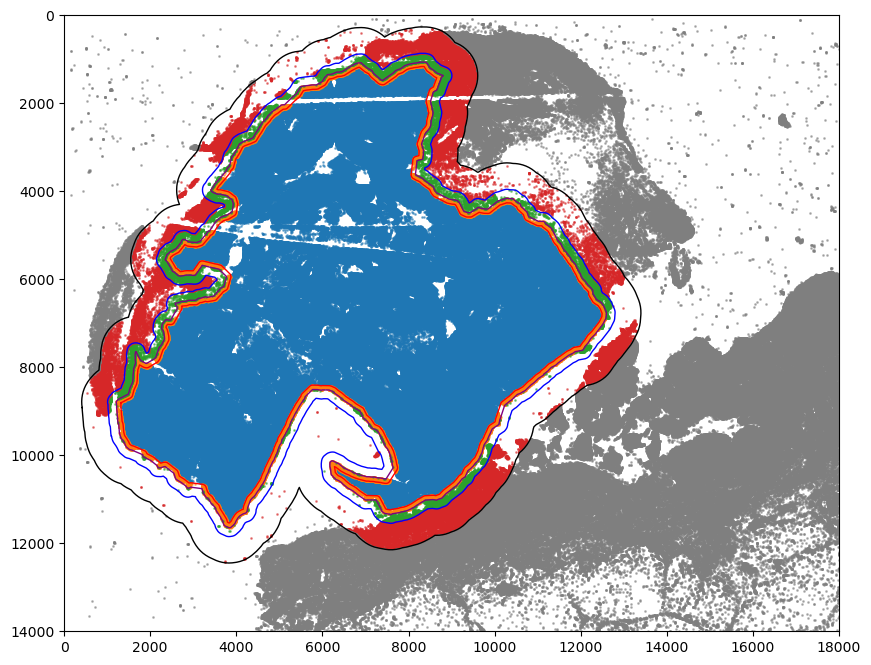

In [30]:
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:gray"]

point_size = 1
fig, ax = plt.subplots(figsize=(10, 8))

for i, region in enumerate(adata.obs["region_rough"].cat.categories):
    tmp = adata[adata.obs.region_rough == region]
    ax.scatter(
        *zip(*tmp.obs[["X_centroid", "Y_centroid"]].to_numpy()),
        s=point_size,
        alpha=0.5,
        label=region,
        color=colors[i]
    )

# Bounds of points in selected commnities
spc.plt.plotBoundary(
    boundaries_rough1, linewidth=1, color="purple", ax=ax, label="Tumor"
)
spc.plt.plotBoundary(ROI_boundaries_rough, linewidth=1, color="k", ax=ax, label="ROI")
spc.plt.plotBoundary(
    shrunken_boundaries_rough, linewidth=1, color="red", ax=ax, label="Shrunken tumor"
)
spc.plt.plotBoundary(
    extended_boundaries_rough, linewidth=1, color="blue", ax=ax, label="Extended tumor"
)
# plt.legend(loc="lower right", markerscale=5)
plt.ylim(14000, 0)
plt.xlim(0, 18000)
# plt.savefig("5_macro_regions.png", dpi=300)
plt.show()

Isolate non-tumor cell holes within the tumor region:

In [32]:
from shapely.geometry import Polygon

holes = spc.spa.getHoles(boundaries1)
final_holes = []
roi_poly = Polygon(
    [
        (6000, 10000),
        (9050, 10000),
        (9050, 6300),
        (6000, 6300),
    ]
)
for hole in holes:
    if hole.intersects(roi_poly):
        final_holes.append(hole)
shrunken_holes = []
extended_holes = []
for i, hole in enumerate(final_holes):
    shrunken_holes.append(spc.spatial.bufferBoundary(hole, -30))
    extended_holes.append(spc.spatial.bufferBoundary(hole, 30))

In [33]:
help(spc.plt.plotRegions)

Help on function plotRegions in module spatialcells.plotting._plotRegions:

plotRegions(regions_list, ax=None, add_label=True, label_prefix='', x_offset=0, y_offset=0, fontsize=12, label_bounds=None, colors_list=['k', 'r', 'b', 'g'], fontcolor='black', foreground_linewidth=5, **kwargs)
    Plot the regions in the regions_list and label them with their index in
    the list.
    labels are placed at the lower left corner of each region. Their position
    can be adjusted by x_offset and y_offset, and the overall label_bounds.
    
    :param regions_list: a list of MultiPolygon regions
    :param add_label: whether to label the regions
    :param ax: the matplotlib ax object.
    :param label_prefix: a prefix to the label of each region
    :param x_offset: the x offset of each label
    :param y_offset: the y offset of the label
    :param fontsize: the fontsize of the label
    :param label_bounds: the bounds of all the label (minx, miny, maxx, maxy).
        If None, the bounds of th

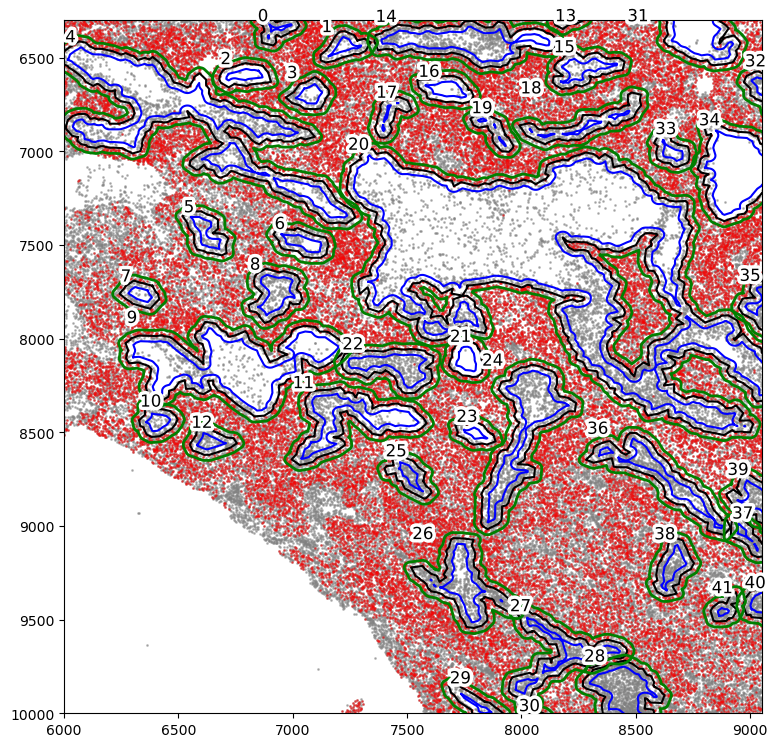

In [34]:
markersize = 1

fig, ax = plt.subplots(figsize=(9, 9))

## all points
ax.scatter(
    *zip(*adata.obs[["X_centroid", "Y_centroid"]].to_numpy()),
    s=markersize,
    color="grey",
    alpha=0.5,
    label="All cells"
)

# Points in selected commnities
xy = adata.obs[
    adata.obs["SOX10+CCND1-"]
][  # [adata.obs[communitycolumn].isin(communityIndexList)][
    ["X_centroid", "Y_centroid"]
].to_numpy()
ax.scatter(
    xy[:, 0],
    xy[:, 1],
    s=markersize,
    color="r",
    marker="o",
    alpha=0.4,
    label="SOX10+CCND1- cells",
)

spc.plt.plotRegions(
    final_holes,
    colors_list=["black"],
    ax=ax,
    label_bounds=(6000, 6300, 9050, 10000),
    x_offset=5,
    y_offset=5,
    add_label=True,
)
spc.plt.plotRegions(shrunken_holes, colors_list=["blue"], ax=ax, add_label=False)
spc.plt.plotRegions(
    extended_holes, colors_list=["green"], ax=ax, add_label=False, linewidth=2
)
plt.ylim(6300, 10000)
plt.xlim(6000, 9050)
ax.invert_yaxis()

In [35]:
for i, hole in enumerate(final_holes):
    boundaries_list = [shrunken_holes[i], hole, extended_holes[i]]
    regions = ["0In", "1Bi", "2Bo"]
    spc.spa.assignPointsToRegions(
        adata, boundaries_list, regions, assigncolumn=f"hole_{i}", default="BG"
    )

0it [00:00, ?it/s]

159it [00:00, 15059.83it/s]


Assigned points to region: 0In


389it [00:00, 22986.21it/s]


Assigned points to region: 1Bi


545it [00:00, 24717.73it/s]


Assigned points to region: 2Bo


79it [00:00, 18220.06it/s]


Assigned points to region: 0In


298it [00:00, 24557.01it/s]


Assigned points to region: 1Bi


514it [00:00, 24785.55it/s]


Assigned points to region: 2Bo


7it [00:00, 4577.51it/s]


Assigned points to region: 0In


111it [00:00, 20959.25it/s]


Assigned points to region: 1Bi


318it [00:00, 19802.08it/s]


Assigned points to region: 2Bo


45it [00:00, 16368.37it/s]


Assigned points to region: 0In


241it [00:00, 13876.79it/s]


Assigned points to region: 1Bi


439it [00:00, 18670.46it/s]


Assigned points to region: 2Bo


8569it [00:00, 12239.67it/s]


Assigned points to region: 0In


9184it [00:00, 16369.07it/s]


Assigned points to region: 1Bi


9428it [00:00, 19331.28it/s]


Assigned points to region: 2Bo


165it [00:00, 22793.63it/s]


Assigned points to region: 0In


305it [00:00, 24602.63it/s]


Assigned points to region: 1Bi


454it [00:00, 24623.24it/s]


Assigned points to region: 2Bo


113it [00:00, 21380.20it/s]


Assigned points to region: 0In


241it [00:00, 24140.89it/s]


Assigned points to region: 1Bi


382it [00:00, 23657.45it/s]


Assigned points to region: 2Bo


34it [00:00, 15337.31it/s]


Assigned points to region: 0In


166it [00:00, 15573.72it/s]


Assigned points to region: 1Bi


308it [00:00, 20740.88it/s]


Assigned points to region: 2Bo


293it [00:00, 12896.21it/s]


Assigned points to region: 0In


437it [00:00, 18728.97it/s]


Assigned points to region: 1Bi


578it [00:00, 20754.82it/s]


Assigned points to region: 2Bo


2313it [00:00, 18936.96it/s]


Assigned points to region: 0In


2914it [00:00, 20212.01it/s]


Assigned points to region: 1Bi


3325it [00:00, 21602.41it/s]


Assigned points to region: 2Bo


69it [00:00, 19840.06it/s]


Assigned points to region: 0In


193it [00:00, 24091.56it/s]


Assigned points to region: 1Bi


343it [00:00, 24756.44it/s]


Assigned points to region: 2Bo


1396it [00:00, 22197.89it/s]


Assigned points to region: 0In


1806it [00:00, 21617.84it/s]


Assigned points to region: 1Bi


2085it [00:00, 23697.53it/s]


Assigned points to region: 2Bo


128it [00:00, 23472.85it/s]


Assigned points to region: 0In


252it [00:00, 25407.80it/s]


Assigned points to region: 1Bi


367it [00:00, 25420.44it/s]


Assigned points to region: 2Bo


295it [00:00, 24452.96it/s]


Assigned points to region: 0In


508it [00:00, 25643.66it/s]


Assigned points to region: 1Bi


596it [00:00, 24377.40it/s]


Assigned points to region: 2Bo


1344it [00:00, 12743.92it/s]


Assigned points to region: 0In


1589it [00:00, 22798.72it/s]


Assigned points to region: 1Bi


1807it [00:00, 24100.06it/s]


Assigned points to region: 2Bo


184it [00:00, 21428.03it/s]


Assigned points to region: 0In


455it [00:00, 23658.44it/s]


Assigned points to region: 1Bi


662it [00:00, 24303.31it/s]


Assigned points to region: 2Bo


28it [00:00, 11428.62it/s]


Assigned points to region: 0In


179it [00:00, 23968.98it/s]


Assigned points to region: 1Bi


421it [00:00, 24933.66it/s]


Assigned points to region: 2Bo


92it [00:00, 14069.71it/s]


Assigned points to region: 0In


302it [00:00, 24358.76it/s]


Assigned points to region: 1Bi


454it [00:00, 24960.20it/s]


Assigned points to region: 2Bo


572it [00:00, 18603.48it/s]


Assigned points to region: 0In


1461it [00:00, 25550.07it/s]


Assigned points to region: 1Bi


1759it [00:00, 24821.12it/s]


Assigned points to region: 2Bo


186it [00:00, 19464.10it/s]


Assigned points to region: 0In


402it [00:00, 25348.56it/s]


Assigned points to region: 1Bi


588it [00:00, 25152.99it/s]


Assigned points to region: 2Bo


19991it [00:03, 6190.09it/s]


Assigned points to region: 0In


19075it [00:02, 7644.09it/s]


Assigned points to region: 1Bi


18563it [00:01, 9923.46it/s] 


Assigned points to region: 2Bo


1it [00:00, 1926.64it/s]


Assigned points to region: 0In


85it [00:00, 19730.80it/s]


Assigned points to region: 1Bi


313it [00:00, 25090.15it/s]


Assigned points to region: 2Bo


591it [00:00, 24106.60it/s]


Assigned points to region: 0In


652it [00:00, 24594.49it/s]


Assigned points to region: 1Bi


737it [00:00, 20282.28it/s]


Assigned points to region: 2Bo


4it [00:00, 4727.31it/s]


Assigned points to region: 0In


105it [00:00, 16284.64it/s]


Assigned points to region: 1Bi


274it [00:00, 18988.16it/s]


Assigned points to region: 2Bo


2798it [00:00, 22993.43it/s]


Assigned points to region: 0In


3021it [00:00, 23991.28it/s]


Assigned points to region: 1Bi


3172it [00:00, 22966.66it/s]


Assigned points to region: 2Bo


219it [00:00, 20791.61it/s]


Assigned points to region: 0In


437it [00:00, 20615.12it/s]


Assigned points to region: 1Bi


578it [00:00, 20965.54it/s]


Assigned points to region: 2Bo


1522it [00:00, 18025.25it/s]


Assigned points to region: 0In


2359it [00:00, 14006.76it/s]


Assigned points to region: 1Bi


2422it [00:00, 23111.58it/s]


Assigned points to region: 2Bo


2186it [00:00, 19627.91it/s]


Assigned points to region: 0In


2900it [00:00, 22858.40it/s]


Assigned points to region: 1Bi


3060it [00:00, 22060.30it/s]


Assigned points to region: 2Bo


1279it [00:00, 23974.63it/s]


Assigned points to region: 0In


1063it [00:00, 25321.56it/s]


Assigned points to region: 1Bi


1115it [00:00, 26420.70it/s]


Assigned points to region: 2Bo


111it [00:00, 22575.17it/s]


Assigned points to region: 0In


478it [00:00, 26430.74it/s]


Assigned points to region: 1Bi


632it [00:00, 25858.19it/s]


Assigned points to region: 2Bo


72it [00:00, 18692.12it/s]


Assigned points to region: 0In


250it [00:00, 24560.27it/s]


Assigned points to region: 1Bi


353it [00:00, 24812.13it/s]


Assigned points to region: 2Bo


2498it [00:00, 17473.70it/s]


Assigned points to region: 0In


3291it [00:00, 22281.75it/s]


Assigned points to region: 1Bi


3796it [00:00, 22696.86it/s]


Assigned points to region: 2Bo


879it [00:00, 25673.15it/s]


Assigned points to region: 0In


969it [00:00, 25438.96it/s]


Assigned points to region: 1Bi


1080it [00:00, 22564.06it/s]


Assigned points to region: 2Bo


70it [00:00, 18291.77it/s]


Assigned points to region: 0In


187it [00:00, 25710.84it/s]


Assigned points to region: 1Bi


342it [00:00, 25239.77it/s]


Assigned points to region: 2Bo


286it [00:00, 22303.91it/s]


Assigned points to region: 0In


753it [00:00, 24957.81it/s]


Assigned points to region: 1Bi


1177it [00:00, 26875.15it/s]


Assigned points to region: 2Bo


153it [00:00, 23501.37it/s]


Assigned points to region: 0In


383it [00:00, 25404.75it/s]


Assigned points to region: 1Bi


456it [00:00, 24574.42it/s]


Assigned points to region: 2Bo


2496it [00:00, 23549.57it/s]


Assigned points to region: 0In


3029it [00:00, 27413.04it/s]


Assigned points to region: 1Bi


3292it [00:00, 23545.70it/s]


Assigned points to region: 2Bo


180it [00:00, 20363.44it/s]


Assigned points to region: 0In


346it [00:00, 21051.22it/s]


Assigned points to region: 1Bi


440it [00:00, 20896.48it/s]


Assigned points to region: 2Bo


351it [00:00, 20081.31it/s]


Assigned points to region: 0In


529it [00:00, 25676.84it/s]


Assigned points to region: 1Bi


647it [00:00, 20525.95it/s]


Assigned points to region: 2Bo


7351it [00:00, 15422.70it/s]


Assigned points to region: 0In


7765it [00:00, 22056.84it/s]


Assigned points to region: 1Bi


7833it [00:00, 20331.47it/s]


Assigned points to region: 2Bo


343it [00:00, 24038.33it/s]


Assigned points to region: 0In


415it [00:00, 23768.79it/s]


Assigned points to region: 1Bi


444it [00:00, 23285.96it/s]


Assigned points to region: 2Bo


35it [00:00, 8441.67it/s]


Assigned points to region: 0In


205it [00:00, 22044.72it/s]


Assigned points to region: 1Bi


303it [00:00, 22737.63it/s]

Assigned points to region: 2Bo


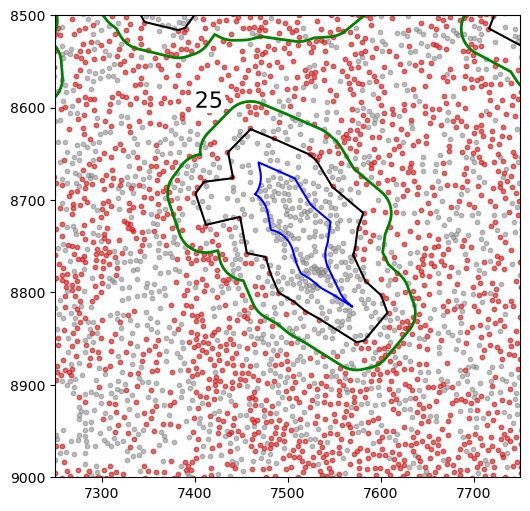

In [36]:
import matplotlib.patheffects as PathEffects

markersize = 10

fig, ax = plt.subplots(figsize=(6, 6))

## all points
ax.scatter(
    *zip(*adata.obs[["X_centroid", "Y_centroid"]].to_numpy()),
    s=markersize,
    color="grey",
    alpha=0.5,
    label="All cells"
)

# Points in selected commnities
xy = adata.obs[
    adata.obs["SOX10+CCND1-"]
][  # [adata.obs[communitycolumn].isin(communityIndexList)][
    ["X_centroid", "Y_centroid"]
].to_numpy()
ax.scatter(
    xy[:, 0],
    xy[:, 1],
    s=markersize,
    color="r",
    marker="o",
    alpha=0.4,
    label="SOX10+CCND1- cells",
)

spc.plt.plotRegions(
    final_holes,
    colors_list=["black"],
    ax=ax,
    label_bounds=(6000, 6300, 9050, 10000),
    x_offset=5,
    y_offset=5,
    add_label=False,
)
spc.plt.plotRegions(shrunken_holes, colors_list=["blue"], ax=ax, add_label=False)
spc.plt.plotRegions(
    extended_holes, colors_list=["green"], ax=ax, add_label=False, linewidth=2
)
txt = plt.text(7400, 8600, "25", fontsize=16, color="black")
txt.set_path_effects([PathEffects.withStroke(linewidth=8, foreground="w")])
plt.ylim(8500, 9000)
plt.xlim(7250, 7750)
ax.invert_yaxis()

In [37]:
def merge_pheno(row):
    if row["phenotype_large_cohort"] in [
        "T cells",
        "Cytotoxic T cells",
        "Exhausted T cells",
    ]:
        return "T cells"
    elif row["phenotype_large_cohort"] in ["Melanocytes"]:
        return "Tumor cells"
    else:
        return "Other cells"


# Applying the function to create the new column
adata.obs["pheno"] = pd.Categorical(adata.obs.apply(merge_pheno, axis=1))

In [38]:
adata.obs.head()

X_centroid  Y_centroid phenotype_large_cohort id  \
0  21807.565909    9.997727                Unknown  0   
1  21896.527273   28.150000                Unknown  1   
2  21891.008824   31.755882                Unknown  2   
3  21893.457692   37.430769                Unknown  3   
4  21888.600000   35.496000                Unknown  4   

   CCND1_cellRingMask_positive  CCND1_negative  SOX10_cellRingMask_positive  \
0                         True           False                        False   
1                         True           False                        False   
2                         True           False                        False   
3                         True           False                        False   
4                         True           False                        False   

   SOX10+CCND1-  COI_community region_rough  ... hole_33 hole_34 hole_35  \
0         False             -2           BG  ...      BG      BG      BG   
1         False             -2           BG  ...      BG      BG      BG   
2         False             -2           BG  ...      BG      BG      BG   
3         False             -2           BG  ...      BG      BG      BG   
4         False             -2           BG  ...      BG      BG      BG   

  hole_36 hole_37 hole_38 hole_39 hole_40 hole_41        pheno  
0      BG      BG      BG      BG      BG      BG  Other cells  
1      BG      BG      BG      BG      BG      BG  Other cells  
2      BG      BG      BG      BG      BG      BG  Other cells  
3      BG      BG      BG      BG      BG      BG  Other cells  
4      BG      BG      BG      BG      BG      BG  Other cells  

[5 rows x 53 columns]

In [39]:
regions = ["Tumor", "Tumor Border", "Stroma Border", "Stroma"]
macro_df = []
for r in regions:
    df = spc.measurements.getRegionComposition(
        adata, "pheno", regions=[r], regioncol="region_rough"
    )
    df["region"] = r
    macro_df.append(df)
df = spc.measurements.getRegionComposition(
    adata, "pheno", regions=regions, regioncol="region_rough"
)
df["region"] = "Overall"
macro_df.append(df)

macro_df = pd.concat(macro_df)
macro_df

pheno  cell_count  composition         region
0  Tumor cells      398217     0.748067          Tumor
1  Other cells      113177     0.212608          Tumor
2      T cells       20934     0.039325          Tumor
0  Tumor cells       33720     0.811045   Tumor Border
1  Other cells        6551     0.157567   Tumor Border
2      T cells        1305     0.031388   Tumor Border
0  Other cells       15152     0.769919  Stroma Border
1  Tumor cells        3160     0.160569  Stroma Border
2      T cells        1368     0.069512  Stroma Border
0  Other cells       47571     0.767027         Stroma
1  Tumor cells       10199     0.164447         Stroma
2      T cells        4250     0.068526         Stroma
0  Tumor cells      445296     0.679215        Overall
1  Other cells      182451     0.278295        Overall
2      T cells       27857     0.042491        Overall

/Users/ghwan/opt/anaconda3/envs/spatialcells/lib/python3.10/site-packages/seaborn/categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Users/ghwan/opt/anaconda3/envs/spatialcells/lib/python3.10/site-packages/seaborn/categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


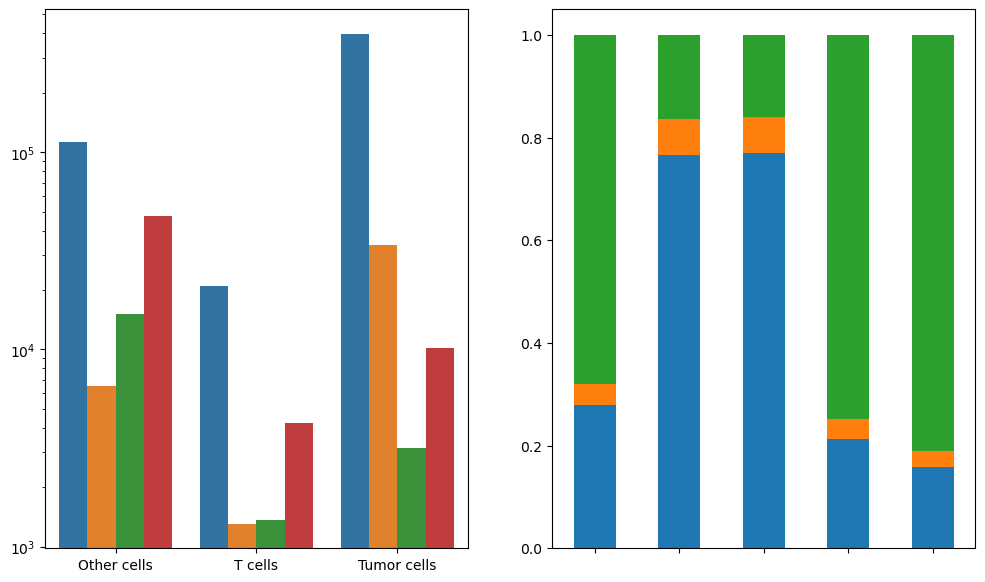

In [40]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 7))
macro_plot_df = macro_df.copy().drop(columns=["composition"])
macro_plot_df = macro_plot_df[macro_plot_df["region"] != "Overall"]

sns.barplot(
    data=macro_plot_df, ax=ax1, x="pheno", y="cell_count", hue="region", palette="tab10"
)
macro_plot_df = macro_df.copy().drop(columns=["cell_count"])
macro_plot_df2 = macro_plot_df.pivot(
    index="region", columns="pheno", values="composition"
)
macro_plot_df2.plot(
    kind="bar",
    stacked=True,
    legend=False,
    ax=ax2,
    color=["tab:blue", "tab:orange", "tab:green"],
)
plt.xticks(rotation=0)
ax1.set_ylabel("", fontsize=14)
ax1.set_xlabel("", fontsize=14)
ax2.set_ylabel("", fontsize=14)
ax2.set_xticklabels(["", "", "", "", ""])
ax2.set_xlabel("", fontsize=14)
ax1.get_legend().remove()
# ax2.legend(loc="lower left", markerscale=5, bbox_to_anchor=(1, 0.5))
ax1.set_yscale("log")
# plt.savefig("5_macro_region_composition_vert.png", dpi=300, bbox_inches='tight')

In [41]:
micro_df = []
regions = ["0In", "1Bi", "2Bo"]
for i in range(len(final_holes)):
    for r in regions:
        df = spc.measurements.getRegionComposition(
            adata, "pheno", regions=[r], regioncol=f"hole_{i}"
        )
        df["region"] = r
        df["hole_id"] = i
        micro_df.append(df)
micro_df = pd.concat(micro_df)
micro_df

pheno  cell_count  composition region  hole_id
0   Other cells           9     1.000000    0In        0
1       T cells           0     0.000000    0In        0
2   Tumor cells           0     0.000000    0In        0
0   Other cells          86     0.530864    1Bi        0
1   Tumor cells          67     0.413580    1Bi        0
..          ...         ...          ...    ...      ...
1   Tumor cells          36     0.327273    1Bi       41
2       T cells          10     0.090909    1Bi       41
0   Tumor cells         162     0.875676    2Bo       41
1   Other cells          14     0.075676    2Bo       41
2       T cells           9     0.048649    2Bo       41

[378 rows x 5 columns]

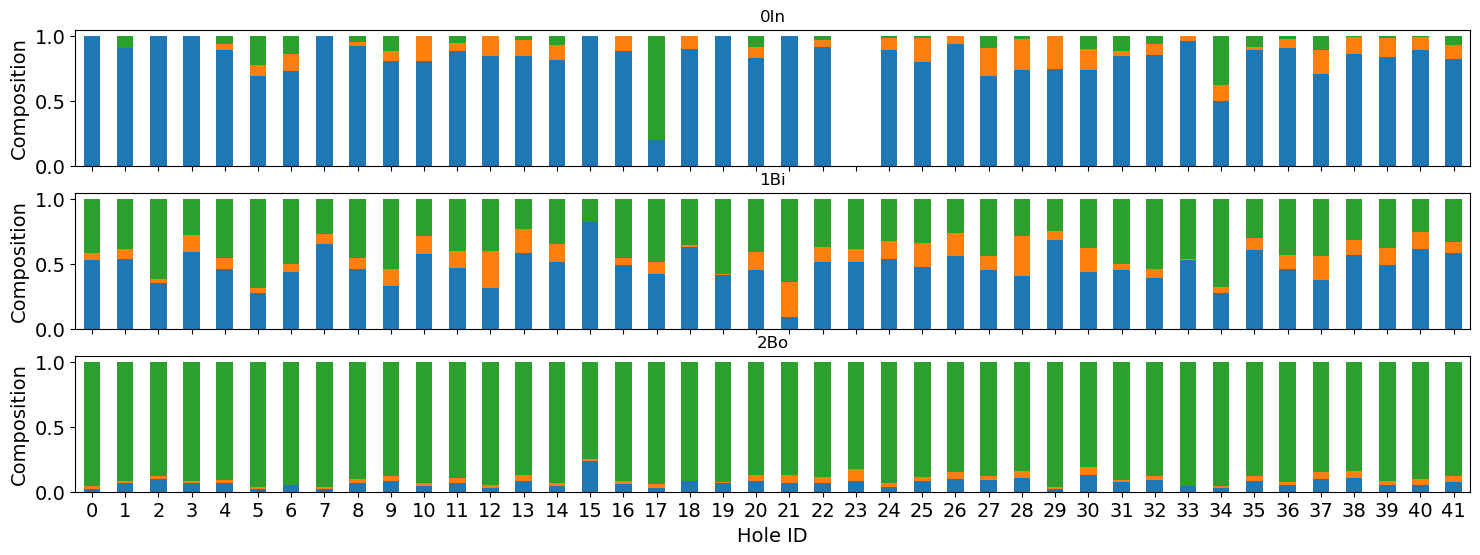

In [42]:
fig, axs = plt.subplots(3, 1, figsize=(6, 18), sharex=True, sharey=True)
micro_plot_df = micro_df.copy().drop(columns=["cell_count"])
for i, r in enumerate(micro_plot_df.region.unique()):
    tmp = micro_plot_df[micro_plot_df.region == r]
    tmp = tmp.pivot(index="hole_id", columns="pheno", values="composition")
    tmp.plot(
        kind="bar",
        stacked=True,
        figsize=(18, 6),
        legend=False,
        ax=axs[i],
        color=["tab:blue", "tab:orange", "tab:green"],
    )
    axs[i].set_title(r)
    plt.sca(axs[i])
    plt.xticks(fontsize=14, rotation=0)
    plt.yticks(fontsize=14)
    plt.ylabel("Composition", fontsize=14)
    plt.xlabel("Hole ID", fontsize=14)
    # plt.legend(loc="lower left", markerscale=5, bbox_to_anchor=(1, 0.5))
# micro_plot_df = micro_plot_df.pivot(index="region", columns="pheno", values="composition")
# micro_plot_df.plot(kind="bar", stacked=True, figsize=(6,6), legend=True, ax=ax1)
# plt.savefig("5_micro_region_composition.png", dpi=300)